In this benchmark, we try to achieve the highest throughput (MB/s) while reading a single ROOT file.

In [1]:
import os, sys
sys.path.append(os.getcwd()+"/../")
from scenarios.generator_2p1 import generate_configs
from src.benchmark import Benchmark, run_benchmark

In [ ]:
# warning: all YAML files will be deleted fron this directory before proceeding
config_path = "./configs_2.1"

generate_configs(config_path)
report = run_benchmark(config_path)

In [3]:
report

,n_files,n_columns_read,n_events,loaded_columns,worker_operation_time,executor,n_workers,compressed_bytes,uncompressed_bytes,run_processor,run,column_setup
0,1,50,154321550,True,0,dask-local,4,265594188,1129031467,18.854903,20.201502,muons_only
1,1,50,154321550,True,0,dask-local,2,265594188,1129031467,36.067419,37.411057,muons_only
2,1,20,61728620,True,0,dask-local,4,175488912,521753090,8.828839,10.453846,hmm_columns
3,1,233,719138423,True,0,dask-local,4,1152109223,5636057591,81.689311,83.107676,main_collections
4,1,233,719138423,True,0,dask-local,2,1152109223,5636057591,158.832810,160.246120,main_collections
5,1,20,61728620,True,0,dask-local,2,175488912,521753090,16.589971,18.113264,hmm_columns


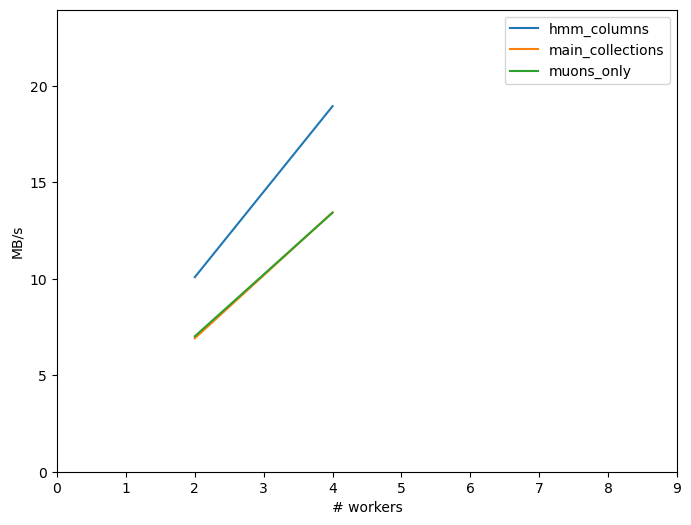

In [4]:
import matplotlib.pyplot as plt

report["MB/s (compressed)"] = report.compressed_bytes/report.run_processor/(1024*1024)

report_by_column_setup = report.groupby('column_setup')

plt.figure(figsize=(8, 6))
for col_setup, group in report_by_column_setup:
    plt.plot(group.n_workers, group["MB/s (compressed)"], label=col_setup)

plt.xlabel('# workers')
plt.ylabel('MB/s')
plt.legend()
plt.xlim(0, report.n_workers.max()+5)
plt.ylim(0, report['MB/s (compressed)'].max() + 5)
plt.show()